<a href="https://colab.research.google.com/github/AnuBaluguri/Deepfake-Detection-/blob/main/TransferLearning_Deepfake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define directories and parameters
main_dir = "/content/drive/MyDrive/Sample Data/Preprocessed2"
img_width, img_height = 224, 224
batch_size = 20


In [5]:
# Function to load images and their corresponding labels
def load_data_from_directory(directory):
    images = []
    labels = []
    for label, subfolder in enumerate(os.listdir(directory)):
        subfolder_path = os.path.join(directory, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)


In [6]:
# Load all data
images, labels = load_data_from_directory(main_dir)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

In [7]:
# Load VGG16 model pretrained on ImageNet without the top classification layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Extract features from the VGG16 model for training and testing images separately
train_features = vgg_model.predict(train_images, batch_size=batch_size)
test_features = vgg_model.predict(test_images, batch_size=batch_size)

181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step


In [9]:
# Flatten the features for input to the Random Forest classifier
num_train_samples = len(train_images)
num_test_samples = len(test_images)
num_features = np.prod(train_features.shape[1:])

In [10]:
train_features_flattened = train_features.reshape(num_train_samples, num_features)
test_features_flattened = test_features.reshape(num_test_samples, num_features)

In [11]:
# Adjust class weights
class_weights = {0: 1, 1: 10}  # Assuming you have two classes, adjust weights as needed

In [12]:
# Initialize and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_flattened, train_labels)

RandomForestClassifier(random_state=42)

In [13]:
# Make predictions on the testing data
predictions = rf_classifier.predict(test_features_flattened)

In [14]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy on the testing set:", accuracy)

Accuracy on the testing set: 1.0


In [15]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

In [16]:
# Calculate precision
precision = precision_score(test_labels, predictions, average='weighted')
print("Precision:", precision)

Precision: 1.0


In [17]:
# Calculate recall
recall = recall_score(test_labels, predictions, average='weighted')
print("Recall:", recall)

Recall: 1.0


In [18]:
# Calculate F1 score
f1 = f1_score(test_labels, predictions, average='weighted')
print("F1 Score:", f1)

F1 Score: 1.0


In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[773   0]
 [  0 771]]


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [22]:
# Assuming predictions are probabilities for the positive class
positive_class_probs = predictions  # Assuming predictions are probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, positive_class_probs)

# Calculate ROC AUC
roc_auc = roc_auc_score(test_labels, positive_class_probs)

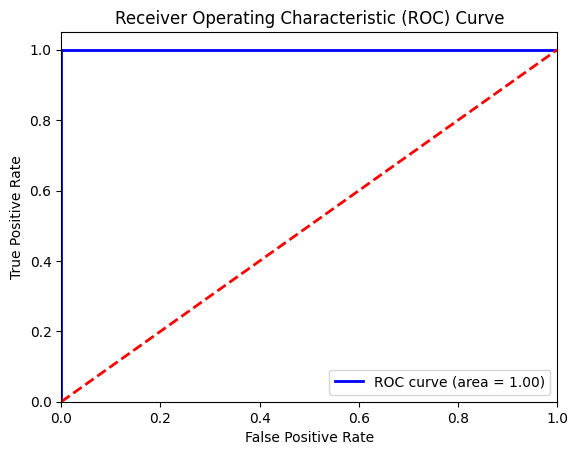

In [23]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()